In [1]:
import numpy as np
import gym

from collections import deque
import torch 
from torch import nn
from torch.optim import Adam
import torch.optim
from torch.distributions import Categorical
import torch.nn.functional as F
from collections import namedtuple
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from collections import namedtuple
from torch.utils.data import Dataset, DataLoader
import os

In [2]:


Memory = namedtuple('Memory', ['state', 'action', 'action_log_prob', 'reward', 'done', 'value'])
AuxMemory = namedtuple('Memory', ['state', 'target_value', 'old_values'])

class ExperienceDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, ind):
        return tuple(map(lambda t: t[ind], self.data))

def create_shuffled_dataloader(data, batch_size):
    ds = ExperienceDataset(data)
    return DataLoader(ds, batch_size = batch_size, shuffle = True)

In [3]:

def exists(val):
    return val is not None

def normalize(t, eps = 1e-5):
    return (t - t.mean()) / (t.std() + eps)

def update_network_(loss, optimizer):
    optimizer.zero_grad()
    loss.mean().backward()
    optimizer.step()

def init_(m):
    if isinstance(m, nn.Linear):
        gain = torch.nn.init.calculate_gain('tanh')
        torch.nn.init.orthogonal_(m.weight, gain)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [4]:


class Actor(nn.Module):
    def __init__(self, state_dim, hidden_dim, num_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
            
        )

        self.action_head = nn.Sequential(
            nn.Linear(hidden_dim, num_actions),
            nn.Softmax(dim=-1)
        )

        self.value_head = nn.Linear(hidden_dim, 1)
        self.apply(init_)

    def forward(self, x):
        hidden = self.net(x)
        return self.action_head(hidden), self.value_head(hidden)

class Critic(nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.apply(init_)

    def forward(self, x):
        return self.net(x)


What if you try to use the Mean abbsolute Loss .Instead of SquareLoss and wqhy it works and why it doesn't areason 

In [5]:
def clipped_value_loss(values, rewards, old_values, clip):
    value_clipped = old_values + (values - old_values).clamp(-clip, clip)
    value_loss_1 = (value_clipped.flatten() - rewards) ** 2
    value_loss_2 = (values.flatten() - rewards) ** 2
    return torch.mean(torch.max(value_loss_1, value_loss_2))

What if we take a mean value and what if we take difference 

In [6]:


class PPG:
    def __init__(
        self,
        state_dim,
        num_actions,
        actor_hidden_dim,
        critic_hidden_dim,
        epochs,
        epochs_aux,
        minibatch_size,
        lr,
        betas,
        lam,
        gamma,
        beta_s,
        eps_clip,
        value_clip,
        device
    ):
        self.device = device

        self.actor = Actor(state_dim, actor_hidden_dim, num_actions).to(device)
        self.critic = Critic(state_dim, critic_hidden_dim).to(device)
        self.opt_actor = Adam(self.actor.parameters(), lr=lr, betas=betas)
        self.opt_critic = Adam(self.critic.parameters(), lr=lr, betas=betas)


        self.minibatch_size = minibatch_size

        self.epochs = epochs
        self.epochs_aux = epochs_aux

        self.lam = lam
        self.gamma = gamma
        self.beta_s = beta_s

        self.eps_clip = eps_clip
        self.value_clip = value_clip

    def save(self):
        torch.save({
            'actor': self.actor.state_dict(),
            'critic': self.critic.state_dict()
        }, f'./ppg_NN_v2.pt')

    def load(self):
        if not os.path.exists('./ppg_NN_v2.pt'):
            return

        data = torch.load(f'./ppg_NN_v2.pt')
        self.actor.load_state_dict(data['actor'])
        self.critic.load_state_dict(data['critic'])

    def learn(self, memories, aux_memories, next_state):
        states = []
        actions = []
        old_log_probs = []
        rewards = []
        masks = []
        values = []

        for mem in memories:
            states.append(mem.state)
            actions.append(torch.tensor(mem.action))
            old_log_probs.append(mem.action_log_prob)
            rewards.append(mem.reward)
            # invert done for GAE calculations
            masks.append(1 - float(mem.done))
            values.append(mem.value)

        # calculate generalized advantage estimate
        next_state = torch.from_numpy(next_state).to(self.device)
        next_value = self.critic(next_state).detach()
        values = values + [next_value]

        returns = []
        gae = 0
        for i in reversed(range(len(rewards))):
            delta = rewards[i] + self.gamma * values[i + 1] * masks[i] - values[i]
            gae = delta + self.gamma * self.lam * masks[i] * gae
            returns.insert(0, gae + values[i])

        # convert values to torch tensors
        to_torch_tensor = lambda t: torch.stack(t).to(self.device).detach()

        states = to_torch_tensor(states)
        actions = to_torch_tensor(actions)
        old_values = to_torch_tensor(values[:-1])
        old_log_probs = to_torch_tensor(old_log_probs)

        rewards = torch.tensor(returns).float().to(self.device)

        # store state and target values to auxiliary memory buffer for later training
        aux_memory = AuxMemory(states, rewards, old_values)
        aux_memories.append(aux_memory)

        # prepare dataloader for policy phase training
        dl = create_shuffled_dataloader([states, actions, old_log_probs, rewards, old_values], self.minibatch_size)

        # policy phase training, similar to original PPO
        for _ in range(self.epochs):
            for states, actions, old_log_probs, rewards, old_values in dl:
                action_probs, _ = self.actor(states)
                values = self.critic(states)
                dist = Categorical(action_probs)
                action_log_probs = dist.log_prob(actions)
                entropy = dist.entropy()

                # calculate clipped surrogate objective, classic PPO loss
                ratios = (action_log_probs - old_log_probs).exp()
                advantages = normalize(rewards - old_values.detach())
                surr1 = ratios * advantages
                surr2 = ratios.clamp(1 - self.eps_clip, 1 + self.eps_clip) * advantages
                policy_loss = - torch.min(surr1, surr2) - self.beta_s * entropy

                update_network_(policy_loss, self.opt_actor)

                # calculate value loss and update value network separate from policy network
                value_loss = clipped_value_loss(values, rewards, old_values, self.value_clip)

                update_network_(value_loss, self.opt_critic)

    def learn_aux(self, aux_memories):
        # gather states and target values into one tensor
        states = []
        rewards = []
        old_values = []
        for state, reward, old_value in aux_memories:
            states.append(state)
            rewards.append(reward)
            old_values.append(old_value)

        states = torch.cat(states)
        rewards = torch.cat(rewards)
        old_values = torch.cat(old_values)

        # get old action predictions for minimizing kl divergence and clipping respectively
        old_action_probs, _ = self.actor(states)
        old_action_probs.detach_()

        # prepared dataloader for auxiliary phase training
        dl = create_shuffled_dataloader([states, old_action_probs, rewards, old_values], self.minibatch_size)

        # the proposed auxiliary phase training
        # where the value is distilled into the policy network, while making sure the policy network 
        #does not change the action predictions (kl div loss)
        for epoch in range(self.epochs_aux):
            for states, old_action_probs, rewards, old_values in tqdm(dl, desc=f'auxiliary epoch {epoch}'):
                action_probs, policy_values = self.actor(states)
                action_logprobs = action_probs.log()

                # policy network loss copmoses of both the kl div loss as well as the auxiliary loss
                aux_loss = clipped_value_loss(policy_values, rewards, old_values, self.value_clip)
                loss_kl = F.kl_div(action_logprobs, old_action_probs, reduction='batchmean')
                policy_loss = aux_loss + loss_kl

                update_network_(policy_loss, self.opt_actor)

                # paper says it is important to train the value network extra during the auxiliary phase
                values = self.critic(states)
                value_loss = clipped_value_loss(values, rewards, old_values, self.value_clip)

                update_network_(value_loss, self.opt_critic)


policy Loss here and figure oput what is is happenining and use the difference , max , avg instead of Sum

In [7]:

def train(
    env_name = 'LunarLander-v2',
    num_episodes = 5000,
    max_timesteps = 500,
    actor_hidden_dim = 32,
    critic_hidden_dim = 256,
    #minibatch_size = 16,
    minibatch_size = 32,
    lr = 0.0005,
    betas = (0.9, 0.999),
    #lam = 0.95,
    lam = 0.90,
    #gamma = 0.99,
    gamma = 0.95,
    eps_clip = 0.2,
    value_clip = 0.4,
    beta_s = .01,
    update_timesteps = 64,
    num_policy_updates_per_aux = 32,
    epochs = 1,
    epochs_aux = 6,
    render = False,
    render_every_eps = 250,
    save_every = 1000,
    load = False,
):
    """
    :param env_name: OpenAI gym environment name
    :param num_episodes: number of episodes to train
    :param max_timesteps: max timesteps per episode
    :param actor_hidden_dim: actor network hidden layer size
    :param critic_hidden_dim: critic network hidden layer size
    :param minibatch_size: minibatch size for training
    :param lr: learning rate for optimizers
    :param betas: betas for Adam Optimizer
    :param lam: GAE lambda (exponential discount)
    :param gamma: GAE gamma (future discount)
    :param eps_clip: PPO policy loss clip coefficient
    :param value clip: value loss clip coefficient
    :param beta_s: entropy loss coefficient
    :param update_timesteps: number of timesteps to run before training
    :param epochs: policy phase epochs
    :param epochs_aux: auxiliary phase epochs
    :param render: toggle render environment
    :param render_every_eps: if render, how often to render
    :param save_every: how often to save networks
    :load: toggle load a previously trained network 
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    env = gym.make(env_name)

    state_dim = env.observation_space.shape[0]
    num_actions = env.action_space.n

    memories = deque([])
    aux_memories = deque([])

    agent = PPG(
        state_dim,
        num_actions,
        actor_hidden_dim,
        critic_hidden_dim,
        epochs,
        epochs_aux,
        minibatch_size,
        lr,
        betas,
        lam,
        gamma,
        beta_s,
        eps_clip,
        value_clip,
        device
    )

    if load:
        agent.load()

    time = 0
    updated = False
    num_policy_updates = 0
    
    
    reward_list = []
    
    for eps in tqdm(range(num_episodes), desc='episodes'):
        render_eps = render and eps % render_every_eps == 0
        state = env.reset()
        total_reward = 0
        
        for timestep in range(max_timesteps):
            time += 1

            if updated and render_eps:
                env.render()

            state = torch.from_numpy(state).to(device)
            action_probs, _ = agent.actor(state)
            value = agent.critic(state)

            dist = Categorical(action_probs)
            action = dist.sample()
            action_log_prob = dist.log_prob(action)
            action = action.item()

            next_state, reward, done, _ = env.step(action)
            total_reward+=reward

            memory = Memory(state, action, action_log_prob, reward, done, value)
            memories.append(memory)

            state = next_state

            if time % update_timesteps == 0:
                agent.learn(memories, aux_memories, next_state)
                num_policy_updates += 1
                memories.clear()

                if num_policy_updates % num_policy_updates_per_aux == 0:
                    agent.learn_aux(aux_memories)
                    aux_memories.clear()

                updated = True

            if done:
                if render_eps:
                    updated = False
                break
                
        reward_list.append(total_reward)
        

        if render_eps:
            env.close()

        if eps % save_every == 0:
            agent.save()
            
    return reward_list

reward_list = train()


d:\ai programme\project\scrap\pybullet\pybullet_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 142.35it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 129.86it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 109.34it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 90.65it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.76it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 76.78it/s]

auxiliary epoch 1: 100%|██████████████████████████

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.58it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 90.90it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.10it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 88.84it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 88.71it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 88.27it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.94it/s]

auxiliary epoch 5: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 88.32it/s]


auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.48it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 80.32it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.73it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.79it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 78.71it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 78.71it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 77.88it/s]

auxiliary epoch 2:   0%|                                                                        | 0/64 [00:00<?, ?it/s]


auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 79.58it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 77.23it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 77.71it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.02it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.58it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 82.60it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 82.72it/s]

auxiliary epoch 4:  14%|█████████                                                       | 9/64 [00:00<00:00, 86.80it/s]


auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 81.80it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.94it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.35it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.77it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.99it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 81.15it/s]

auxiliary epoch 0:  31%|███████████████████▋                                           | 20/64 [00:00<00:00, 88.07it/s]


auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.68it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 81.45it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 81.38it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 80.23it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 81.13it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 81.54it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 80.92it/s]

auxiliary epoch 2:  59%|█████████████████████████████████████▍                         | 38/64 [00:00<00:00, 80.37it/s]


auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 81.74it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 79.39it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 78.13it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 80.92it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 81.58it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 80.37it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 80.80it/s]

auxiliary epoch 4:  84%|█████████████████████████████████████████████████████▏         | 54/64 [00:00<00:00, 80.77it/s]


auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 79.68it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 81.47it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 78.33it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 77.47it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 79.39it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 77.81it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 80.27it/s]



auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 80.28it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 79.17it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 81.14it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 78.22it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.48it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 82.50it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.14it/s]

auxiliary epoch 3:  14%|█████████                                                       | 9/64 [00:00<00:00, 82.74it/s]


auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 82.27it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 81.39it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.08it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.72it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 82.15it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 82.63it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 82.50it/s]

auxiliary epoch 5:  28%|█████████████████▋                                             | 18/64 [00:00<00:00, 82.98it/s]


auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 88.20it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 91.35it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 82.44it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 82.88it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.44it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.91it/s]

auxiliary epoch 1:  70%|████████████████████████████████████████████▎                  | 45/64 [00:00<00:00, 80.69it/s]


auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 81.94it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 80.21it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.32it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.22it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 79.68it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 80.01it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 77.80it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 77.89it/s]

auxiliary epoch 4:   0%|        

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 77.01it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.99it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 80.88it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.25it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 78.08it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 78.61it/s]

auxiliary epoch 0:  42%|██████████████████████████▌                                    | 27/64 [00:00<00:00, 79.32it/s]


auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 78.62it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 78.29it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 77.03it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 78.25it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 81.91it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 89.81it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 98.40it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 80.79it/s]

auxiliary epoch 3:   0%|        

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 80.50it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.02it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 91.65it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 95.46it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 91.53it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 93.65it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 94.30it/s]

episodes:   4%|██▊                                                                | 206/5000 [04:37<2:57:05,  2.22s/it]


auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.06it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.41it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 88.71it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.36it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.99it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.79it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.03it/s]

auxiliary epoch 2:  78%|█████████████████████████████████████████████████▏             | 50/64 [00:00<00:00, 87.77it/s]


auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 90.17it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.50it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.32it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 92.89it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 102.38it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 125.55it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 121.92it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 105.37it/s]

auxiliary epoch 0:  42%|████████

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.11it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.00it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.66it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 92.11it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.13it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.74it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.59it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.68it/s]



auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 82.60it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.03it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.86it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.65it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.08it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.79it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.20it/s]

auxiliary epoch 5:   0%|                                                                        | 0/64 [00:00<?, ?it/s]


auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.86it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.40it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.27it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 93.24it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.08it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 88.25it/s]

auxiliary epoch 1:  75%|███████████████████████████████████████████████▎               | 48/64 [00:00<00:00, 87.18it/s]


auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.35it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.52it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.98it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.45it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.88it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.45it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.22it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.48it/s]

auxiliary epoch 4:  14%|████████

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 98.26it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.27it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.91it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.60it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.34it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.72it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.85it/s]



auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 93.35it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 94.26it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.74it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 94.46it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.00it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.96it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.64it/s]

auxiliary epoch 3:  84%|█████████████████████████████████████████████████████▏         | 54/64 [00:00<00:00, 81.95it/s]


auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 82.70it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.87it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.12it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.02it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 82.36it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 80.87it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 82.87it/s]

auxiliary epoch 5: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 81.32it/s]


auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.53it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.87it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.69it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.79it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.38it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.09it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 88.99it/s]

auxiliary epoch 2:  61%|██████████████████████████████████████▍                        | 39/64 [00:00<00:00, 89.38it/s]


auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 88.70it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 88.45it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.72it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 89.28it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.23it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.60it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 88.98it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.53it/s]

auxiliary epoch 5:  75%|████████

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.69it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.13it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.98it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 88.17it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 99.19it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.51it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.87it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.67it/s]

auxiliary epoch 3:   0%|        

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.22it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.30it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.92it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.69it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.84it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.06it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.04it/s]

auxiliary epoch 5:  59%|█████████████████████████████████████▍                         | 38/64 [00:00<00:00, 85.88it/s]


auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.69it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.06it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.01it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.18it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 82.39it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 90.91it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.22it/s]

auxiliary epoch 2:  28%|█████████████████▋                                             | 18/64 [00:00<00:00, 89.29it/s]


auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.22it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.93it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.84it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 89.77it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 99.28it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 150.70it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 137.76it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 142.03it/s]

auxiliary epoch 0:  41%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 104.61it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 120.96it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 115.03it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 115.20it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 130.30it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 125.45it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 121.26it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 124.31it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 100.81it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 115.18it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 111.25it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 109.42it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 96.61it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.42it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.16it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.58it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.50it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.48it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.62it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.20it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.13it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.83it/s]

auxiliary epoch 0:  59%|█████████████████████████████████████▍                         | 38/64 [00:00<00:00, 85.04it/s]


auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.96it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.43it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.85it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.03it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.83it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.91it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.48it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.76it/s]

auxiliary epoch 3:  28%|████████

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.39it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.30it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.78it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.50it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.12it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.67it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 82.83it/s]

auxiliary epoch 5:  42%|██████████████████████████▌                                    | 27/64 [00:00<00:00, 84.96it/s]


auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.31it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.99it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.10it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.11it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 85.80it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 82.81it/s]

auxiliary epoch 1:  84%|█████████████████████████████████████████████████████▏         | 54/64 [00:00<00:00, 85.63it/s]


auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.98it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 82.80it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 82.34it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.17it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.61it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.90it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.38it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.09it/s]

auxiliary epoch 4:   0%|        

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.79it/s]

auxiliary epoch 0: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.65it/s]

auxiliary epoch 1: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 95.81it/s]

auxiliary epoch 2: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 86.11it/s]

auxiliary epoch 3: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 83.80it/s]

auxiliary epoch 4: 100%|███████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 87.45it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 202.12it/s]

auxiliary epoch 1:   0%|                                                                        | 0/64 [00:00<?, ?it/s]


auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 210.25it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 193.67it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 198.14it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 194.53it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 215.49it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 208.44it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 217.67it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 215.84it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 191.60it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 191.58it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 194.53it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 196.92it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 192.19it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 191.05it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 195.12it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 188.24it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 190.46it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 191.62it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 189.91it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 190.48it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 191.33it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 199.36it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 198.14it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 195.12it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 323.23it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 282.56it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 296.25it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.94it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 310.68it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 326.68it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 299.07it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 303.32it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 323.23it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 325.56it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 299.05it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 324.87it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 309.18it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 324.01it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 320.00it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.29it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 306.22it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 304.71it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 315.27it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 285.72it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 289.60it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 335.08it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 279.48it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 293.58it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 313.64it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 319.98it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 303.32it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.66it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 283.19it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 331.57it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.56it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 294.93it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 299.12it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 303.00it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 336.10it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 297.52it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.51it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 334.60it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 332.16it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 294.77it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 301.76it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 342.30it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 331.60it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 341.42it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 284.38it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 326.58it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 341.79it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 300.37it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 328.73it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 290.45it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 286.03it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.65it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.08it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 295.75it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.77it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.34it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 315.86it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.85it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 329.51it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 325.78it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 293.32it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 279.87it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 291.60it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 322.65it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 297.37it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 278.71it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 289.50it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 294.50it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 297.99it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 303.23it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 289.88it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 320.49it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 288.29it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 289.21it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 325.60it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 336.41it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.10it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 309.33it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 305.64it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.88it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 315.80it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 294.36it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 315.94it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 282.52it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 323.08it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 293.72it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 318.68it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 288.32it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 319.13it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 327.23it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 326.05it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 315.33it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 325.97it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 303.15it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 277.72it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 296.33it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.50it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 331.50it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 332.35it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.74it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 331.40it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 318.27it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 296.89it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.04it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 317.79it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 320.10it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 321.46it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.69it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 311.74it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 286.48it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 316.97it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 309.81it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 289.85it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 331.71it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 327.77it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.36it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 333.39it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 268.08it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.12it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.06it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 292.01it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 283.57it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.67it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 305.90it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 302.07it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 291.33it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 333.41it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 316.63it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 268.82it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 321.01it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 331.78it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 309.02it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 249.07it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 258.83it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 287.44it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 337.84it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 272.52it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 314.71it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.59it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 279.67it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.41it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 268.91it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.26it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.61it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 300.50it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.59it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 312.07it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 312.87it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 239.73it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 303.12it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 318.36it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 291.27it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 311.05it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 303.38it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 294.43it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 300.21it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 324.25it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 313.18it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 301.77it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 314.38it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 304.76it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 294.63it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 318.41it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 324.88it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 258.16it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.85it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 285.75it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 346.08it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 307.61it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.18it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 292.26it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 288.49it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 295.02it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 300.13it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.20it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 308.19it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 295.75it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 288.53it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 303.63it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 277.11it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 326.74it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 277.75it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 302.28it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 327.90it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 260.82it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 290.53it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.11it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 302.00it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 320.36it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.41it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 326.99it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.71it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.08it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 303.29it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 301.34it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 279.50it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 331.72it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 327.89it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 294.13it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 294.99it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 313.69it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 315.74it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.15it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 282.95it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 313.32it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 293.73it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 284.03it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 325.50it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 301.97it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 318.81it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 308.00it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 304.65it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 339.87it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 293.28it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 299.30it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.85it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.12it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 298.26it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 311.60it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 268.44it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 290.69it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 348.34it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 315.72it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 290.37it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 319.47it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 300.86it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 276.81it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 317.14it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 321.41it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 290.94it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 289.53it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 320.11it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 283.16it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.26it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 290.52it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.93it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 304.17it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 269.40it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.61it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 260.23it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 330.56it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 269.39it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 284.45it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.29it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 329.84it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 326.54it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 335.08it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 331.61it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.03it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 301.89it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 299.07it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 293.55it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.98it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 272.35it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 279.47it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 296.30it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.83it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 268.20it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.98it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 288.81it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 272.96it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 239.64it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 276.58it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 289.79it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 287.86it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 308.46it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 282.57it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.34it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 269.01it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 295.96it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 298.82it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 333.04it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 287.65it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 299.29it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 291.10it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 272.40it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.93it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.71it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 286.55it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 309.89it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 293.77it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 297.75it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 320.83it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 208.87it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.43it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.62it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.95it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 290.70it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.06it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.37it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 299.10it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 321.05it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 308.72it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.50it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 269.03it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 269.65it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.65it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 301.32it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 326.89it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 293.81it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 303.58it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 287.63it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 313.73it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 328.21it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 305.47it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 277.69it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 315.81it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 293.23it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 308.81it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 317.34it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 328.75it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 306.19it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.23it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.33it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.41it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 304.25it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 319.98it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.58it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 277.07it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 305.80it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 292.60it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 287.24it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.70it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.75it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.09it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 298.98it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 276.48it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.50it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 314.80it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 249.28it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.69it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 286.13it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.14it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.72it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 278.52it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 268.45it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.29it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.56it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.92it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 299.27it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 280.24it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 303.95it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.49it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.87it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 280.97it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 295.72it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 289.28it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 284.04it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.77it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 286.25it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.40it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 286.29it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 286.13it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 341.70it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 301.36it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 279.03it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 329.51it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 276.72it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 317.07it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 298.91it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 277.06it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.51it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.94it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 297.67it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 292.24it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 279.48it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 294.21it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 278.26it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.94it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 280.70it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 285.92it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.35it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 287.58it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.20it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.62it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 278.96it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.69it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 277.20it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.34it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.29it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 260.64it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 284.79it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.49it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 283.15it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.61it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 276.36it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.32it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.51it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 279.45it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.64it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.53it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.61it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.04it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 299.07it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 279.44it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 287.00it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.10it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.82it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 292.24it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 268.91it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 321.61it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 296.29it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 296.30it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 301.80it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 293.11it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.95it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.02it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.80it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 301.42it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.39it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 279.10it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.15it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.68it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 280.02it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 278.18it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.50it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.77it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.84it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.77it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 319.93it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 279.49it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.22it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.98it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 269.53it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 268.31it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.28it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 293.86it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.64it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 278.17it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 293.77it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 296.68it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 282.45it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 276.42it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 290.46it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 279.22it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 284.33it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 289.26it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 312.14it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 282.35it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.74it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.76it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 230.20it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.80it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 213.76it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.94it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.24it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 289.65it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 280.40it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.14it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 268.96it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.47it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 283.78it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.46it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.55it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.59it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.43it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.28it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.54it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 272.70it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.60it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.37it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.60it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 287.54it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 239.70it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.64it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 287.27it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.33it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 249.87it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 279.08it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.61it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 298.61it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.83it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.52it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.70it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.99it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.50it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.99it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 278.11it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.56it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.22it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.00it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.72it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.66it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.97it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.07it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.13it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 301.63it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 308.48it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.95it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.15it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.09it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.10it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.62it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 294.85it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.81it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.70it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 269.65it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 277.72it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.95it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 240.62it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 276.12it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 239.73it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 282.88it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 285.31it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.39it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.15it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.30it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.11it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.98it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.95it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.14it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.80it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 278.22it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.68it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.28it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 284.44it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.92it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.58it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.89it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 283.80it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.41it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.51it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.01it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 291.34it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.26it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 280.48it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.26it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.32it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.32it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 269.45it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 272.35it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 272.51it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.32it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.86it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.35it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.09it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 269.71it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.69it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 276.22it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.74it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 258.41it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.77it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.23it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.93it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 287.00it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 292.24it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 306.22it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 299.07it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 290.91it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.30it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 303.32it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 293.58it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.31it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.02it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 289.51it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.61it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.12it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.32it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.94it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.24it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.71it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 284.60it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 283.73it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 272.15it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 299.59it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.81it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 283.36it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.90it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 269.21it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 294.91it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 278.58it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 288.50it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 277.66it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.55it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.65it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.51it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 286.71it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 324.05it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 287.90it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.01it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 302.89it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 310.71it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.50it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.29it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 329.09it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 284.12it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 301.50it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 292.11it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 310.47it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.28it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 293.47it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 296.54it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.26it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.43it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.04it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.06it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 279.43it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.98it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.34it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 291.26it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.39it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 278.55it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.73it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 283.09it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.73it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.92it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.33it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 258.08it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.07it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.37it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.96it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 229.69it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 249.43it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.33it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.00it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.60it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.06it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.69it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.48it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.72it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.82it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 225.42it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.24it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.03it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.57it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.03it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 279.92it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.31it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.97it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 290.74it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 289.53it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.11it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 286.06it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.61it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.25it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.98it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.60it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.92it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.90it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.17it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.62it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.37it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.38it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.98it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.51it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 268.00it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.56it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 249.05it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 268.13it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.39it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.80it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 269.84it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.42it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.15it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.25it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.27it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.26it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.40it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 284.14it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.19it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 277.26it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.65it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 258.04it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.21it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.11it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 217.31it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 258.57it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.09it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.57it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.03it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 279.47it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.04it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.16it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.11it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.04it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 225.39it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.92it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.79it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.11it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.39it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.37it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.20it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.18it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 276.54it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.55it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.14it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.14it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.74it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 295.63it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 284.20it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.04it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.85it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 277.03it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.28it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 311.12it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 280.09it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 284.79it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.30it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.19it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 222.06it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.93it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.58it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.00it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.33it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.14it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.94it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.06it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 260.47it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 258.68it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 309.40it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.54it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 285.77it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.36it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.61it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 286.65it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 277.99it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.37it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 277.98it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 276.13it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.95it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.65it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.60it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.68it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.87it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.00it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 296.30it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.78it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 299.06it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.63it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 269.67it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 288.71it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.09it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 278.38it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.37it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.98it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.48it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 283.65it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.23it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.52it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.85it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 284.83it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.09it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 228.07it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.93it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.40it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 276.69it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 290.92it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 272.86it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.43it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.24it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 269.97it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 277.90it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.83it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 225.83it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.20it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.76it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.78it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.95it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 240.99it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.02it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 306.14it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.96it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 308.25it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.61it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.01it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 288.19it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.27it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.33it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.76it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.42it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.50it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 240.89it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 258.61it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.67it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.26it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.93it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 289.58it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 299.31it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 325.97it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 302.20it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 290.79it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.64it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.73it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 249.74it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 260.16it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 249.03it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.97it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.98it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.92it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.37it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.21it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.30it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 283.19it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.94it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 260.12it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.51it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.85it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.01it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.53it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.67it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 232.03it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 239.21it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.25it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.51it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.06it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.40it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.74it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 298.40it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.31it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.86it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.08it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.50it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.81it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.87it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.44it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 229.76it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.13it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.60it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.92it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.46it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.35it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.09it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.31it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 291.22it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.37it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.98it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.71it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.84it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.52it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 285.73it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 249.30it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.85it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.70it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.76it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 282.78it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 302.34it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.77it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 314.16it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 291.98it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 317.97it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.70it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.12it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.57it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.24it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.56it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 301.67it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.84it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.99it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.78it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 280.53it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 282.52it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 240.71it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.81it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.76it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 288.05it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.81it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.24it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.10it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 225.96it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 232.94it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.08it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 280.99it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.19it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.86it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.76it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.91it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 229.30it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 278.21it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 229.48it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.62it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.10it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.93it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 287.26it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.51it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.34it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.62it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.60it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.33it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.87it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.80it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 228.91it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.60it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 288.98it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 276.69it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.88it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 282.51it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.10it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 225.90it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 278.23it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 302.12it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 278.32it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 287.25it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.65it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.81it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.95it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.41it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 277.40it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.77it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 216.72it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.74it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 231.01it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.70it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 284.77it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 268.50it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.83it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.24it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 221.40it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 311.08it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 282.49it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 311.67it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.94it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.03it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 210.10it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.44it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 190.18it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 195.91it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 192.19it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 219.18it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 219.71it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.11it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.70it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.59it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.00it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.46it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 224.99it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.46it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 217.72it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.07it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.62it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.65it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.29it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.69it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.27it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.65it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.93it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 292.93it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.45it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 192.17it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.81it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.60it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.46it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.39it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.50it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.92it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 276.33it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.03it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 280.17it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 216.98it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 291.93it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.85it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.75it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 290.26it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 311.67it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 315.51it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.31it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 276.21it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.96it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.70it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.05it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.70it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.41it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.65it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 282.98it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.68it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.86it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.42it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 283.14it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 279.47it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.12it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.11it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.99it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 278.25it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.84it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.97it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.03it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 260.16it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.33it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 283.67it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.73it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 249.60it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.16it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 269.51it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.57it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.26it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.78it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.51it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.14it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.28it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.21it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.66it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.53it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.41it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.68it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 309.18it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 284.45it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 292.90it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 301.89it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.04it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 299.02it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 284.45it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.46it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.94it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.03it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 285.07it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 283.81it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 268.91it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.77it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 282.86it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.19it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 291.60it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 293.93it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 289.33it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 287.22it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 288.47it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.20it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 240.20it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 283.12it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 295.78it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 272.61it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.46it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.47it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 289.81it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 269.77it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 294.75it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 290.91it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 299.06it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 279.47it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 304.76it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 306.22it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 303.31it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 300.47it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 286.99it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 294.89it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 290.91it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.50it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 304.76it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.19it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 293.53it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 307.69it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 285.71it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.50it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.03it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.39it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.25it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 287.66it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.60it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 277.76it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 277.64it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.48it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.93it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.21it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 282.59it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.26it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.40it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 285.70it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 287.10it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.76it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 289.43it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 288.70it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 309.54it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.04it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 288.40it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.60it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 277.06it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.38it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.22it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.97it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.88it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.01it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.65it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.12it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 169.67it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.65it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 287.22it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 286.95it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.99it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.80it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 260.29it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.55it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.02it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.26it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 301.96it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 292.46it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 290.56it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.16it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 239.45it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.15it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.48it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.45it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.38it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 224.56it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.67it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 328.33it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 303.26it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 307.70it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 328.21it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 260.53it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 230.68it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.53it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 276.20it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 301.59it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 272.20it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.20it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.61it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.11it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.09it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.65it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.17it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 240.76it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.02it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.53it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.96it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.96it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 278.32it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.99it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 220.06it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.65it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.58it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.26it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 239.70it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.28it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.35it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.04it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.51it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.83it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.00it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.30it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.00it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.69it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.07it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 277.06it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.74it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.80it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.44it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 283.36it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.11it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.13it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.61it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.96it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.00it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.19it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.38it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.92it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.93it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.49it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 240.97it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.63it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.96it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.20it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.39it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.46it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 219.50it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.88it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.69it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.40it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.01it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.89it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.65it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 240.02it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 202.27it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.02it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 282.25it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.55it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 276.40it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.43it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.66it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.54it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 232.99it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.54it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 231.92it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 197.86it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.35it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.90it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.22it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 239.52it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.51it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 312.19it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 316.83it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 308.87it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.10it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 283.19it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 289.60it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 280.70it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 282.24it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 293.58it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 258.07it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 269.45it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 285.72it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 299.07it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.58it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 300.90it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 298.94it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.91it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 260.81it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.81it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 286.25it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.32it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.34it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 260.35it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 299.93it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 217.72it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.70it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.90it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.99it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.51it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 260.73it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.36it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.84it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.97it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 283.03it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 278.63it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.62it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 210.93it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.03it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.62it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.34it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.21it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.88it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.88it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.40it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.17it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 297.60it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.16it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.57it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.39it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 239.83it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.77it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.24it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.41it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 224.45it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.61it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.40it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.14it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 311.78it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.28it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.95it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 272.13it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.06it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.43it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.11it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.59it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.98it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.21it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.03it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.38it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.21it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.56it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 269.46it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 288.14it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.52it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.83it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.84it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.84it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 260.44it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.27it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.58it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.92it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.61it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.98it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 239.68it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.13it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.78it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 283.72it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.30it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.57it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.04it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.81it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.67it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.51it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 258.06it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.74it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.98it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.51it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.82it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 279.48it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 268.91it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.05it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.16it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.11it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.19it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.39it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.03it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.07it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.93it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.95it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.50it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 232.76it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.07it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.23it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.78it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 296.50it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.75it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.00it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.39it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.75it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 277.41it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.38it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.46it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 249.03it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.97it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.34it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.67it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.51it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.81it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.18it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.06it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.04it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 271.19it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.78it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 249.03it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.94it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.74it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 276.12it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.83it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 306.36it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.81it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 285.23it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.19it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.20it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.65it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 207.44it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.01it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.37it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.13it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.13it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.13it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.15it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 260.51it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 213.33it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 258.06it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.96it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.11it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.96it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.21it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 222.22it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 229.39it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 240.60it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.10it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.86it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 260.16it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 228.59it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.01it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 223.75it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.91it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.81it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.52it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.08it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.72it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 285.57it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.97it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.79it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 231.12it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.82it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 209.36it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.52it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 217.33it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.79it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.50it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.89it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.64it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.59it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.36it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.38it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.99it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.26it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 222.99it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.08it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.81it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.92it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.49it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.55it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.29it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.64it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.12it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 268.93it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.60it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 222.12it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.50it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 293.69it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.59it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.04it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.26it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.75it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.27it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 266.46it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 289.37it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.63it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 267.76it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.19it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.03it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.51it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.00it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.26it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 285.72it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.04it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 272.34it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.79it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.26it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 258.07it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.35it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 193.47it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 207.99it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 258.76it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 225.10it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.40it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.80it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.21it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.47it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 232.93it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.22it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 260.58it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.69it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.28it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.62it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 258.36it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.34it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.59it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 228.48it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 239.70it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.43it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.80it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 231.89it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 231.05it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 223.00it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 224.54it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.00it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.09it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.73it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.14it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.45it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.16it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.27it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.00it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.98it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.33it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.10it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.69it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.58it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 249.79it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.86it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.62it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.15it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.29it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 213.21it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.93it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.15it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.90it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.91it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.71it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.97it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 240.69it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 205.35it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 202.45it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.11it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 208.35it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.02it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 201.86it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 216.45it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 192.98it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 210.74it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.61it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 196.81it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.49it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 204.90it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.20it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.76it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 214.10it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 232.85it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 212.69it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.37it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.70it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 222.28it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 269.96it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 249.50it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.90it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.54it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.83it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.43it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.37it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.15it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.23it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.97it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.43it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 229.39it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.16it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 272.34it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.98it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.03it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.18it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.91it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 214.27it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 204.29it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.32it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.90it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.66it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.14it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.10it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.14it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 216.87it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 231.42it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.96it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 269.00it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.37it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.28it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 221.26it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 232.41it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 204.27it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.64it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.13it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.08it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.66it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.72it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.97it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.75it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.59it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.84it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.18it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 214.04it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.64it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.40it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.85it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.63it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.13it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 210.35it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.57it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.48it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.94it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 203.75it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 210.81it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 274.37it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.69it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.79it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 220.41it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.31it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.86it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.68it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.98it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 231.02it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.06it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.04it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.04it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.98it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 249.01it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 216.95it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.03it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.43it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.79it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.98it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.94it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.21it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 228.97it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.11it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.53it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.14it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.73it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.70it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 270.36it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.57it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 249.63it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 223.09it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 202.56it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.95it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 223.40it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.11it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.53it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.14it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 230.95it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.09it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 219.93it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.16it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.92it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.44it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.21it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 232.73it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.72it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.81it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.29it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.97it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 240.60it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.30it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.72it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.32it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.71it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.39it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.10it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 210.68it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 232.75it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.45it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.14it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.26it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.48it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.83it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.60it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.45it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.15it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 240.29it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.48it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.27it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.26it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.92it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 197.66it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.11it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 216.66it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 228.80it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.00it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.35it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.70it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.13it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 275.27it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 225.93it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.63it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.34it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 229.59it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.75it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.17it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.50it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 265.70it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 258.42it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 228.02it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.56it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 258.28it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 272.61it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.96it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.20it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.44it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.44it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 249.72it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.31it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.60it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.30it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.43it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.06it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 224.56it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 210.17it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 223.78it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 231.05it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 220.67it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 228.57it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.92it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 223.78it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.99it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.39it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 249.35it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 205.40it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 215.67it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 198.20it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.94it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.22it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.74it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.55it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.83it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.42it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.10it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.31it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.54it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.15it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 210.60it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 230.74it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 225.30it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 201.49it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 224.45it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.09it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 214.77it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 223.27it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.02it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.16it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.67it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 201.22it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.25it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 216.44it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.77it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 209.52it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.19it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.21it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.18it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.03it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.58it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.63it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 224.88it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 212.01it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 225.63it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 229.80it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.59it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.86it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 212.08it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.20it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 222.88it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.68it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.74it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.86it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.64it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 272.09it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.71it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.15it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.23it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 278.98it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.80it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.94it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.28it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 228.56it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 258.14it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.47it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.10it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.27it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 208.34it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.10it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.20it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.38it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 260.80it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.95it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.17it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.81it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.52it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.36it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.27it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.78it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 230.79it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.02it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.38it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 231.04it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 257.03it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.21it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.04it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 230.22it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 230.22it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.97it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.35it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 219.18it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 219.18it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.74it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 217.10it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.80it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.60it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.36it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 231.68it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.36it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.99it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 225.98it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 204.06it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.67it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.52it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.74it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 203.47it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 221.65it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 209.76it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.15it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.22it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 223.00it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.76it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 207.79it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.92it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 232.63it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 214.00it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 223.76it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 239.70it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 208.75it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 222.22it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.43it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.39it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.11it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 228.36it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.27it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 212.03it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.12it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.59it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 230.13it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 224.71it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 225.58it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 229.67it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 212.65it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.82it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 192.90it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.33it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.33it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.79it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 212.07it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.55it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.98it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.68it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.34it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.77it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.20it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 268.32it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 216.93it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.66it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 220.79it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.95it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 232.32it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.17it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 217.19it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 230.49it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.68it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.70it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 200.38it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.00it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.53it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.27it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 239.29it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 225.80it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.05it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.38it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 239.12it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.73it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 228.71it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.84it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.59it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 213.21it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.50it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 229.39it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 219.18it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.81it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 205.45it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 215.06it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.52it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 221.62it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 216.88it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.43it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 231.94it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.71it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 212.35it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.08it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.84it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 216.63it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.84it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 232.49it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.93it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 187.12it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 205.39it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.19it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.17it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.63it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.49it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.19it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.49it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 207.01it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.79it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 203.53it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 216.60it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.80it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.77it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 224.68it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 220.17it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 205.41it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.24it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 203.96it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.46it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 204.82it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 225.29it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.99it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.46it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.64it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.16it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.76it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.07it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 223.37it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.59it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.80it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.18it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 221.73it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.67it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.62it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.75it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 203.76it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.30it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 231.89it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 222.22it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.81it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.90it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 219.93it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 219.93it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 223.78it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.92it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.16it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.34it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 217.69it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.45it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.00it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.35it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 223.00it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 190.48it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 191.61it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.02it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 209.80it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.02it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 239.85it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.31it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.68it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.83it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.55it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 197.04it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.18it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.69it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.33it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 205.77it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 229.61it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 193.93it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 230.22it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 215.49it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.35it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.04it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 239.70it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.43it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 230.63it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.04it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.22it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.15it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 212.63it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 214.75it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 221.42it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.16it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.38it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.63it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.47it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 221.41it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 205.71it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.48it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 225.19it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 199.51it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.19it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 181.09it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.13it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.34it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.70it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.73it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 228.21it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.38it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.85it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.67it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 219.35it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 217.80it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 203.86it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 223.70it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 222.16it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 212.71it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 185.64it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.99it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 219.16it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 192.95it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 220.07it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.53it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.45it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 215.25it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 225.92it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.23it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.68it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.64it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.70it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 204.32it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 213.53it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 221.96it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 171.29it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 219.59it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.54it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.23it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.60it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 212.71it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 201.42it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.48it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 232.36it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 180.12it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 231.58it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.97it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.83it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.21it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 225.73it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.58it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 217.48it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 216.96it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.57it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.13it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.85it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 222.74it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.08it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 216.12it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.88it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.30it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 231.82it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.47it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 219.69it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.21it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.60it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.43it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 229.05it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 216.25it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.15it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 207.10it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.02it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 214.77it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 200.61it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 212.63it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 231.05it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 219.98it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.72it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.14it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 219.09it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.99it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 224.82it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 192.45it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.04it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.00it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.65it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 225.37it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 230.15it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.23it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 197.60it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.35it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 249.45it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 199.76it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 212.82it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 187.83it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.63it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 192.71it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 220.24it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 222.21it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 224.99it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 198.14it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 180.10it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 203.73it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.79it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.56it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.81it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 216.97it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.25it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.32it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.80it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 239.18it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 210.80it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 213.98it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 215.17it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 204.39it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.88it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.60it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 205.71it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.48it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 223.70it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 220.90it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.59it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 240.56it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.89it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 185.92it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 201.16it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 232.34it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.12it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.92it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 217.69it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.22it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 194.52it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 184.93it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.15it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 230.58it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.48it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 231.05it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.24it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 222.90it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 232.73it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.87it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 217.69it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 230.66it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.05it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 204.81it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 205.77it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 217.79it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 231.59it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 220.27it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 230.49it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.67it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 210.75it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.63it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 184.70it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 217.84it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.78it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.38it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.12it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.78it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 223.46it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 212.96it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 229.26it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 191.78it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.82it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 204.48it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 208.29it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 231.92it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.15it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 240.47it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 240.83it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.06it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.69it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 224.63it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.29it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.99it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.51it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 217.81it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.34it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.33it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 223.14it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.36it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.67it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.92it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 232.02it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.32it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.31it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 204.27it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 220.59it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 204.16it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.00it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.40it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.80it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 230.22it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.03it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.54it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 210.51it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 215.52it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 229.56it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.26it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 224.06it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.76it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 220.25it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 229.42it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.17it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 217.38it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 231.71it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 225.76it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.26it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 221.20it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 248.06it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 217.07it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.61it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.17it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 210.42it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.78it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.38it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.96it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 216.79it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.21it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.00it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.00it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 232.70it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.21it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 256.00it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 228.57it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 240.60it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.62it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.44it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 229.39it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.65it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.14it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.65it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.62it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 208.67it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.80it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 201.94it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 178.39it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.09it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.26it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.31it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.88it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.63it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 202.71it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.74it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.36it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 211.36it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 228.99it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 203.86it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 230.00it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 203.66it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.49it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.97it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 244.29it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 264.86it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.78it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 228.14it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.42it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 229.66it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 204.33it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 231.89it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.31it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 210.72it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.02it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.96it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 240.41it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 219.99it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 197.85it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.42it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.41it/s]

auxiliary epoch 2: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 232.52it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 196.27it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 239.48it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.25it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.88it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 223.39it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 207.04it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.12it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 238.21it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.46it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.62it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.52it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.30it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 245.61it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 212.71it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.11it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 226.44it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.86it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.10it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.63it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 224.79it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.94it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.54it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 225.46it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 291.66it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 263.96it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 246.04it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 290.37it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.46it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.30it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 251.81it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.11it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.85it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.84it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 250.41it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.03it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 240.92it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 228.73it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 239.40it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.94it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 239.70it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 237.92it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.43it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.98it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.10it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.29it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 241.48it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 240.60it/s]

auxiliary epoch 1: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.19it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.63it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 227.34it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.77it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 203.78it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 218.96it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 228.18it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 236.17it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.54it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 229.28it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 249.42it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 261.47it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 212.88it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.01it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.49it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 219.30it/s]

auxiliary epoch 0: 100%|████████

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.82it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 215.79it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 255.02it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.39it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 273.28it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.87it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.85it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.23it/s]

auxiliary epoch 3: 100%|████████

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 210.82it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 228.27it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 198.83it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.04it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.15it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 232.59it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 259.18it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 252.93it/s]

auxiliary epoch 4: 100%|████████

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 233.41it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.30it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 234.60it/s]

auxiliary epoch 2: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.32it/s]

auxiliary epoch 3: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 253.68it/s]

auxiliary epoch 4: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 243.60it/s]

auxiliary epoch 0: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 254.10it/s]

auxiliary epoch 1: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 262.00it/s]

auxiliary epoch 2: 100%|████████

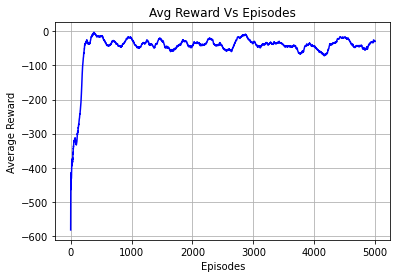

In [8]:
import matplotlib.pyplot as plt

avg_reward_list = np.zeros(len(reward_list))
for i in range(len(avg_reward_list)):
    avg_reward_list[i] = np.mean(reward_list[max(0, i-100):(i+1)])
    
ep = [i  for i in range(len(avg_reward_list))]
plt.plot( range(len(avg_reward_list)),avg_reward_list,'b')
plt.title("Avg Reward Vs Episodes")
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.grid(True)
plt.show()

In [9]:
def test_agent(env_name = 'LunarLander-v2', 
               num_timesteps=10000,
               actor_hidden_dim = 32,
               critic_hidden_dim = 256,
               minibatch_size = 16,
               epochs = 1,
               epochs_aux = 6,
               lr = 0.0005,
               betas = (0.9, 0.999),
               lam = 0.95,
               gamma = 0.99,
               eps_clip = 0.2,
               value_clip = 0.4,
               beta_s = .01,
):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    num_actions = env.action_space.n
    avg_rewards_list = []

    agent = PPG(
        state_dim,
        num_actions,
        actor_hidden_dim,
        critic_hidden_dim,
        epochs,
        epochs_aux,
        minibatch_size,
        lr,
        betas,
        lam,
        gamma,
        beta_s,
        eps_clip,
        value_clip,
        device
    )

    agent.load()

    state = env.reset()
    for _ in range(num_timesteps):
        state = torch.Tensor(state[np.newaxis, :]).to(device)
        action_probs, _ = agent.actor(state)
        dist = Categorical(action_probs)
        action = dist.sample().item()
        state, rewards, dones, info = env.step(action)
        env.render()
        if dones == True: 
            env.reset()
    env.close()

test_agent()

d:\ai programme\project\scrap\pybullet\pybullet_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
